# Neural Network capable of predicting FFF properties

***Written by Gerardo A. Mazzei Capote***

*Last revision: 11/2021*

In [1]:
# Import dependencies

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
# Import TensorFlow, keras, and SciKitLearn dependencies

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import keras_tuner as kt

print(tf.__version__)

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
print(sklearn.__version__)

from keras_tuner import HyperModel

%load_ext tensorboard

2.3.0
0.24.1


In [7]:
from numpy.random import seed

# setting the seed
seed(0)
tf.random.set_seed(0)

## Importing, manipulating, and cleaning the data

<div class="alert alert-block alert-info">
<b>Note:</b> The data used was generated by combining tensile testing data and printer sensor data through a separate python code.
</div> 

* Original *.csv* file includes 'Filepath' information, as well as markers related to run number, sample number and additional notes to gather troubleshooting errors. These columns are not useful here and thus they are dropped. 
* Since the 'Temperature' parameter was kept constant at 230 C, this information will be dropped. The field will remain in the raw dataset in case someone desires to explore this feature in the future.
* Column names are too verbose for code syntax, thus they are being renamed using a dictionary and pandas.
* Converts "E" column to numeric values.
* This model uses the *Filament Speed Ratio*, $S_r$, as one of the inputs, see below for how it was calculated.

In [8]:
raw_df = pd.read_csv('data.csv', encoding= 'unicode_escape').drop(columns=['Filepath', 'Avg Temperature [°C]', 'Run', 'Sample', 'Notes'])
a = {"Orientation [°]": "O", "Layer Height [mm]": "LH", "Nozzle Diameter [mm]": "ND",
    "Print Speed [mm/min]":"PS", "Avg Filament Speed [mm/s]":"S", "Avg Force [g]":"F",
    "Modulus [MPa]":"E","Tensile Stress at Tensile Strength [MPa]":"σ\u209C"}
df = raw_df.rename(columns=a)
df.head()

,O,LH,ND,PS,S,F,E,σₜ
0,0,0.1,0.3,1200,0.36,870.77,2515.99,38.84
1,0,0.1,0.3,1200,0.43,870.32,2343.66,39.45
2,0,0.1,0.3,1200,0.24,826.45,2654.49,39.62
3,0,0.1,0.3,1200,0.24,793.59,2273.61,39.34
4,0,0.1,0.3,1200,0.24,793.59,3208.57,40.65


### Theoretical Filament Speed calculation

This calculation assumes that the filament diameter is constant and equal to 1.75 mm. Thus, the expected filament speed can be solved through the following volumetric balance at the nozzle:

1. $$V_{out} = LH . ND . l$$
2. $$V_{in} = \frac{\pi . D^2 . L}{4}$$
3. Equating Eqn. (1) and (2) yields $$L = \frac{LH. ND. l. 4}{\pi . D^2}$$
4. The expected time to print a bead of lenght $l$ is $$t = \frac{l. 60 s}{PS}$$
5. Thus the theoretical filament speed $S_t$ is $$\frac{4. LH. ND. PS}{\pi . D^2 . 60}$$

In [9]:
df["S_t"] = 4* df["LH"] * df["ND"] * df["PS"] / (np.pi* (1.75**2)*60)
df["S_r"] = df['S']/df['S_t'] 
df

,O,LH,ND,PS,S,F,E,σₜ,S_t,S_r
0,0,0.1,0.3,1200,0.36,870.77,2515.99,38.84,0.249451,1.443169
1,0,0.1,0.3,1200,0.43,870.32,2343.66,39.45,0.249451,1.723785
2,0,0.1,0.3,1200,0.24,826.45,2654.49,39.62,0.249451,0.962113
3,0,0.1,0.3,1200,0.24,793.59,2273.61,39.34,0.249451,0.962113
4,0,0.1,0.3,1200,0.24,793.59,3208.57,40.65,0.249451,0.962113
...,...,...,...,...,...,...,...,...,...,...
471,90,0.4,0.8,3600,5.73,2355.06,1487.67,4.18,7.982432,0.717826
472,90,0.4,0.8,3600,5.54,2078.41,1294.87,3.83,7.982432,0.694024
473,90,0.4,0.8,3600,5.71,2023.24,1367.56,5.92,7.982432,0.715321
474,90,0.4,0.8,3600,5.85,2172.25,1421.15,4.20,7.982432,0.732859


In [10]:
df_mod = df.drop(columns=['S', 'S_t'])
df_mod.head()

,O,LH,ND,PS,F,E,σₜ,S_r
0,0,0.1,0.3,1200,870.77,2515.99,38.84,1.443169
1,0,0.1,0.3,1200,870.32,2343.66,39.45,1.723785
2,0,0.1,0.3,1200,826.45,2654.49,39.62,0.962113
3,0,0.1,0.3,1200,793.59,2273.61,39.34,0.962113
4,0,0.1,0.3,1200,793.59,3208.57,40.65,0.962113


## Creating the training and testing dataset

This portion of the code uses the standard 80-20 split. However, if the split is random, the dataset could be biased given its nature. This portion of the code uses a stratified test/train split to ensure the proportionality of the data is kept during the split.

In [11]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(df_mod, df_mod["O"]):
    strat_train_set = df_mod.loc[train_index]
    strat_test_set = df_mod.loc[test_index]

### Defining helper functions

These help by normalizing the data and process the output targets (in this case F, E, TS).

In [12]:
# Helper functions

#NORMALIZATION FUNCTION

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


#OUTPUT FORMATTING
def format_output(data):
    y1 = data.pop('F')
    y1 = np.array(y1)
    y2 = data.pop('E')
    y2 = np.array(y2)
    y3 = data.pop('σ\u209C')
    y3 = np.array(y3)
    return y1, y2, y3

In [13]:
# Get F, E, and TS as the 3 outputs and format them as np arrays

train_stats = strat_train_set.describe()
#train_stats.pop('S')

train_stats.pop('F')
train_stats.pop('E')
train_stats.pop('σ\u209C')

train_stats = train_stats.transpose()


train_Y = format_output(strat_train_set)
test_Y = format_output(strat_test_set)
# val_Y = format_output(val)

print(train_stats)

     count         mean         std         min          25%         50%  \
O    380.0    43.815789   45.043723     0.00000     0.000000     0.00000   
LH   380.0     0.228421    0.121263     0.10000     0.100000     0.20000   
ND   380.0     0.514211    0.220955     0.30000     0.300000     0.40000   
PS   380.0  2431.578947  974.098667  1200.00000  1200.000000  2400.00000   
S_r  380.0     0.908689    0.086260     0.60132     0.873794     0.92453   

             75%          max  
O      90.000000    90.000000  
LH      0.400000     0.400000  
ND      0.800000     0.800000  
PS   3600.000000  3600.000000  
S_r     0.962113     1.443169  


In [15]:
norm_train_X = np.array(norm(strat_train_set))
norm_test_X = np.array(norm(strat_test_set))
print(norm_train_X)

[[-0.973  1.415 -0.969 -1.264  0.387]
 [ 1.025 -1.059  1.293 -1.264  0.271]
 [ 1.025 -1.059 -0.517 -1.264  0.968]
 ...
 [ 1.025 -0.234 -0.969 -1.264  0.619]
 [ 1.025 -0.234 -0.969  1.199 -0.775]
 [-0.973 -0.234 -0.969 -0.032  0.387]]


### Look for correlations between variables 

The code below uses the Pearson coefficient to determine likelihood of linear correlation between parameters and expected outputs.

In [16]:
df.corr()

,O,LH,ND,PS,S,F,E,σₜ,S_t,S_r
O,1.000000,-0.056162,0.062993,0.042078,-0.008341,0.040565,-0.187742,-0.838546,0.025078,-0.331603
LH,-0.056162,1.000000,-0.017813,-0.010566,0.606848,0.599996,-0.171346,-0.075399,0.576909,-0.194318
ND,0.062993,-0.017813,1.000000,0.050884,0.533117,-0.386903,-0.262839,-0.265973,0.515484,-0.204186
PS,0.042078,-0.010566,0.050884,1.000000,0.474853,0.392609,-0.153039,-0.103450,0.492991,-0.485719
S,-0.008341,0.606848,0.533117,0.474853,1.000000,0.389205,-0.299677,-0.176540,0.978749,-0.408359
F,0.040565,0.599996,-0.386903,0.392609,0.389205,1.000000,-0.091311,-0.005182,0.398594,-0.257384
E,-0.187742,-0.171346,-0.262839,-0.153039,-0.299677,-0.091311,1.000000,0.351055,-0.347648,0.313060
σₜ,-0.838546,-0.075399,-0.265973,-0.103450,-0.176540,-0.005182,0.351055,1.000000,-0.243789,0.488053
S_t,0.025078,0.576909,0.515484,0.492991,0.978749,0.398594,-0.347648,-0.243789,1.000000,-0.515703
S_r,-0.331603,-0.194318,-0.204186,-0.485719,-0.408359,-0.257384,0.313060,0.488053,-0.515703,1.000000


### Set up plotting functions

These functions will make it easier to visualize how the model performs with the test data set.

In [17]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred, alpha= 0.5, color = '#ba423a')
    plt.title(title)
    plt.xlabel('True Values',fontname='Arial', fontsize=20)
    #ax.set_ylabel("Median Population", )
    plt.ylabel('Predictions', fontname='Arial', fontsize=20)
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-10000, 10000], [-10000, 10000],'#f51607') 
    plt.rcParams['figure.dpi'] = 300
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=16)
    plt.title(title, fontsize = 20)
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 0.8
    ax = plt.gca()
    ax.set_facecolor("white")
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.legend(loc='upper center', shadow=True)
    plt.show()

## Setting up the Neural Network

The code below is used to create the model and iterate using the hyperparameter tuning tool

<div class="alert alert-block alert-info">
<b> Multi-output: </b> Model with 3 branches, each with one output layer.
</div> 

In [18]:
class FFFMultiOutputModel(HyperModel):
        
    def build_branch(self, hp):
        
        """All branches will have the same basic architecture"""
        x = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(1)(x)
        
        return x
    
    def model_assembly(self, hp):
        """Used to construct the branches running in parallel and assemble the model"""
        
        inputs = keras.Input(shape = (5,)) #input layer
        x= inputs
        
        #speed_branch = self.build_branch(x)
        force_branch = self.build_branch(x)
        E_branch = self.build_branch(x)
        TS_branch = self.build_branch(x)
        
        model = tf.keras.model(inputs = inputs,
                              outputs = [force_branch,
                                        E_branch, TS_branch],
                              name = "FFF_S_pred")
        return model

In [19]:
def model_assembly(hp):
    
    """Used to construct the branches running in parallel and assemble the model"""
        
    inputs = tf.keras.Input(shape=((len(strat_train_set .columns)))) #input layer
    
  
    "Force Branch"
    y = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(inputs)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(y)
    y = tf.keras.layers.Dropout(0.5)(y)
    F_output = tf.keras.layers.Dense(units='1', name='F_output')(y)
    
    "Modulus Branch"
    w = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(inputs)
    w = tf.keras.layers.Dropout(0.5)(w)
    w = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(w)
    w = tf.keras.layers.Dropout(0.5)(w)
    E_output = tf.keras.layers.Dense(units='1', name='E_output')(w)
    
    "TS Branch"
    z = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(inputs)
    z = tf.keras.layers.Dropout(0.5)(z)
    z = tf.keras.layers.Dense(hp.Int('units', 32, 72, step=16, default=32),activation='relu')(z)
    z = tf.keras.layers.Dropout(0.5)(z)
    TS_output = tf.keras.layers.Dense(units='1', name='TS_output')(z)       
     
    model = tf.keras.Model(inputs = inputs,
                              outputs = [F_output, E_output, TS_output],
                              name = "FFF_pred")
    
    model.compile(
    optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss={'F_output' :'mse', 'E_output' :'mse', 'TS_output' :'mse'}, 
    metrics={'F_output' : tf.keras.metrics.RootMeanSquaredError(),
            'E_output' : tf.keras.metrics.RootMeanSquaredError(),
            'TS_output' : tf.keras.metrics.RootMeanSquaredError()},)
    
    return model

In [20]:
tuner = kt.Hyperband(model_assembly,
                    objective = 'val_loss',
                    max_epochs= 30,
                    hyperband_iterations= 2,
                    directory = (os.path.normpath('C:/Users/Sager')),
                    project_name="multi_out_speed"
                    )

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Sager\multi_out_speed\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Sager\multi_out_speed\tuner0.json


In [21]:
tuner.search(norm_train_X, train_Y,
             validation_data=(norm_test_X, test_Y),
             epochs=30,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],)

INFO:tensorflow:Oracle triggered exit


In [22]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

In [23]:
tuner.results_summary()

Results summary
Results in C:\Users\Sager\multi_out_speed
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.00912470672476799
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: e73e64867c4b866a7d12f3adb2606528
Score: 324630.96875
Trial summary
Hyperparameters:
units: 48
learning_rate: 0.009330909313080183
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: ebd6966c87031ca1f3a8a87b16c29bd1
Score: 341505.84375
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.006997708001704712
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 78dc430c1766f433df0a366613692f1c
Score: 365981.09375
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.006656935943917136
tuner/epochs: 30
tuner/initial_epoch: 10
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 954ea14756665c751b8df5677cae5146
Score: 368590.65625


Use set of best hyperparameters to create and train new model.

In [24]:
model = tuner.hypermodel.build(best_hyperparameters)
history = model.fit(norm_train_X, train_Y,
                    epochs=300, batch_size=20, validation_data=(norm_test_X, test_Y),
                   callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)],)

Epoch 1/300
19/19 [==============================] - 1s 62ms/step - loss: 6375659.0000 - F_output_loss: 965392.0625 - E_output_loss: 5409778.5000 - TS_output_loss: 487.6810 - F_output_root_mean_squared_error: 982.5436 - E_output_root_mean_squared_error: 2325.8931 - TS_output_root_mean_squared_error: 22.0835 - val_loss: 5850737.5000 - val_F_output_loss: 837372.0000 - val_E_output_loss: 5013180.0000 - val_TS_output_loss: 185.7031 - val_F_output_root_mean_squared_error: 915.0803 - val_E_output_root_mean_squared_error: 2239.0132 - val_TS_output_root_mean_squared_error: 13.6273
Epoch 2/300
19/19 [==============================] - 0s 7ms/step - loss: 5875107.5000 - F_output_loss: 818800.3125 - E_output_loss: 5056178.0000 - TS_output_loss: 129.6864 - F_output_root_mean_squared_error: 904.8759 - E_output_root_mean_squared_error: 2248.5947 - TS_output_root_mean_squared_error: 11.3880 - val_loss: 4838031.5000 - val_F_output_loss: 554871.7500 - val_E_output_loss: 4283046.0000 - val_TS_output_loss

19/19 [==============================] - 0s 6ms/step - loss: 507462.2812 - F_output_loss: 115654.9922 - E_output_loss: 391759.7812 - TS_output_loss: 47.4064 - F_output_root_mean_squared_error: 340.0809 - E_output_root_mean_squared_error: 625.9072 - TS_output_root_mean_squared_error: 6.8852 - val_loss: 238601.7031 - val_F_output_loss: 57443.9844 - val_E_output_loss: 181131.6250 - val_TS_output_loss: 26.0875 - val_F_output_root_mean_squared_error: 239.6747 - val_E_output_root_mean_squared_error: 425.5956 - val_TS_output_root_mean_squared_error: 5.1076
Epoch 30/300
19/19 [==============================] - 0s 7ms/step - loss: 483835.1875 - F_output_loss: 96532.5391 - E_output_loss: 387255.0312 - TS_output_loss: 47.6804 - F_output_root_mean_squared_error: 310.6969 - E_output_root_mean_squared_error: 622.2982 - TS_output_root_mean_squared_error: 6.9051 - val_loss: 243898.5469 - val_F_output_loss: 61732.7773 - val_E_output_loss: 182146.3750 - val_TS_output_loss: 19.4192 - val_F_output_root_me

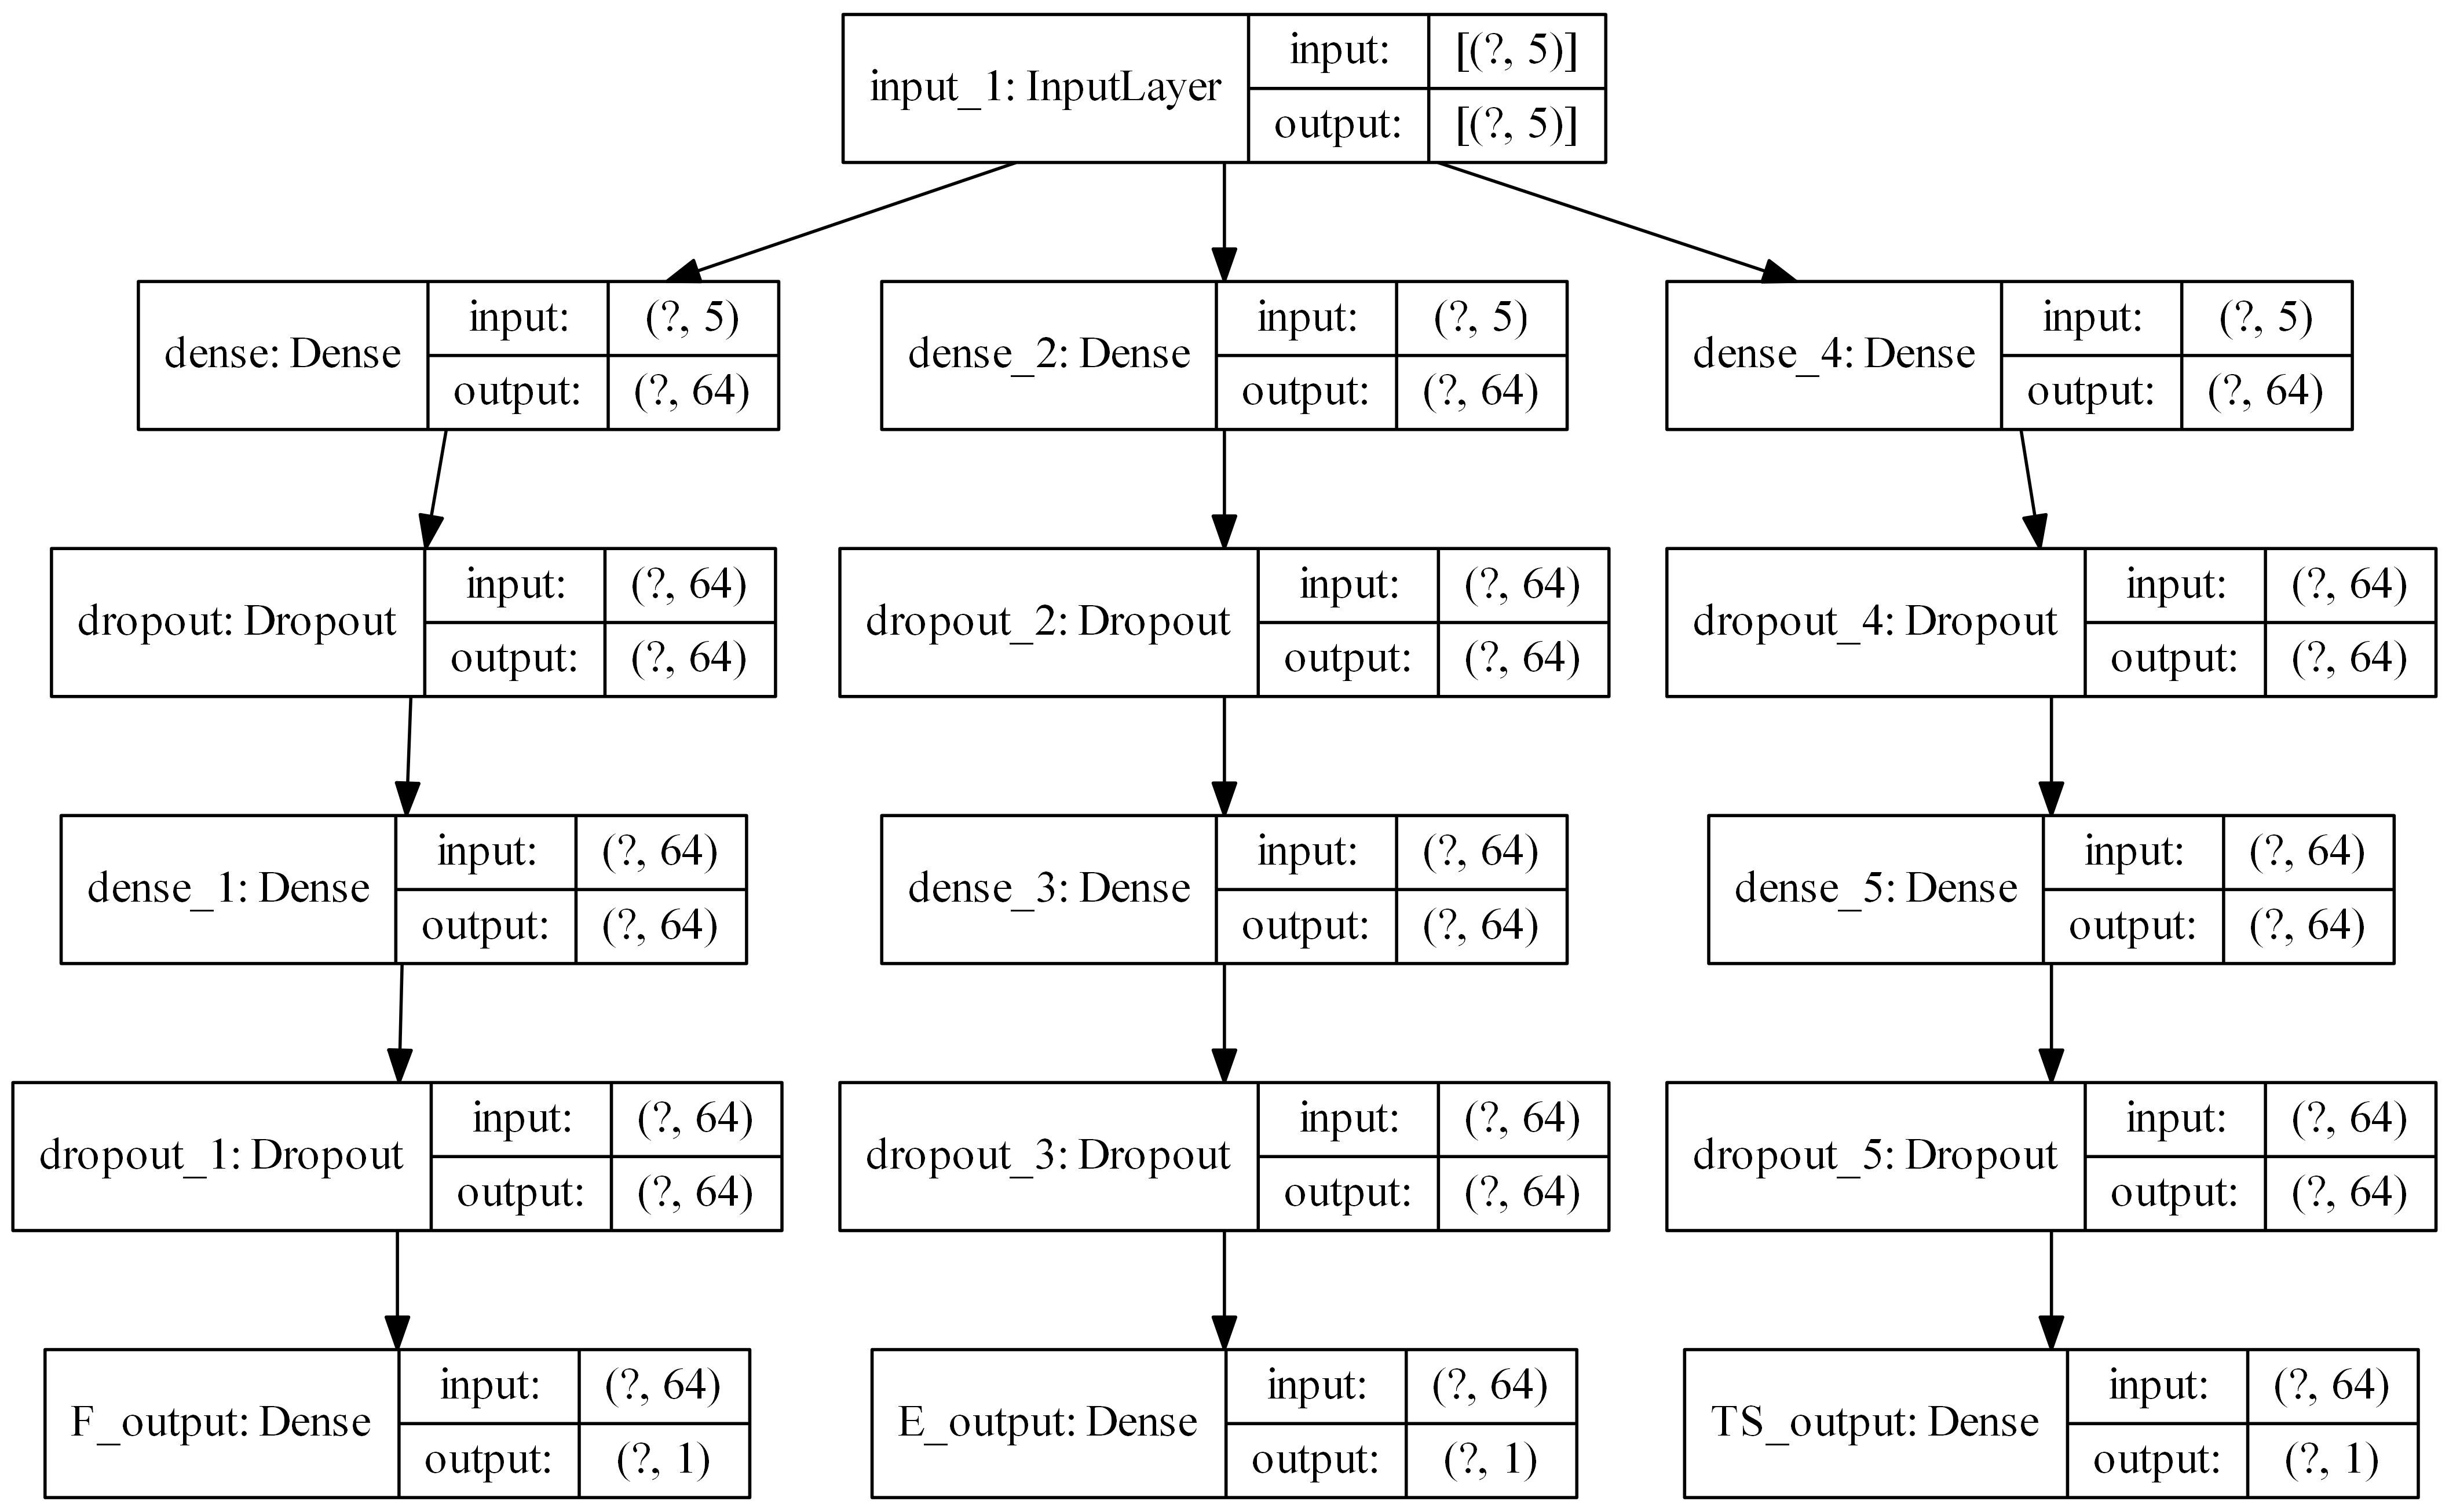

In [25]:
keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True, dpi=400)

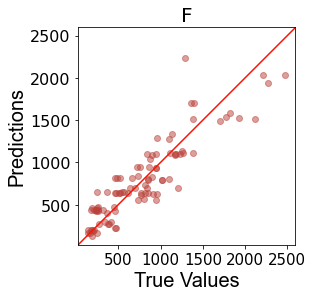

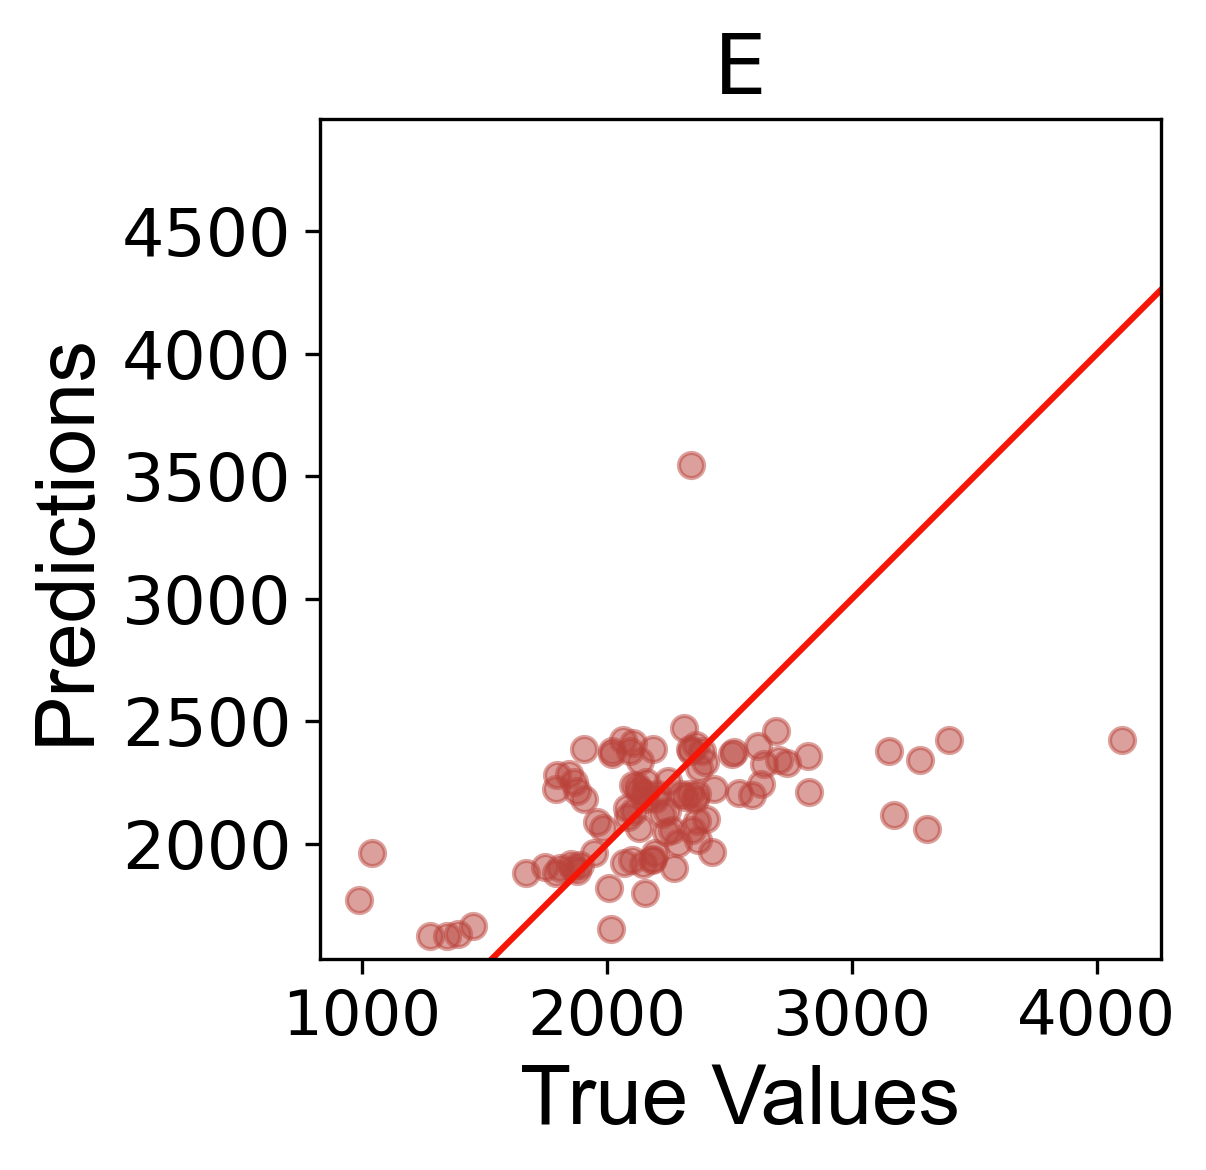

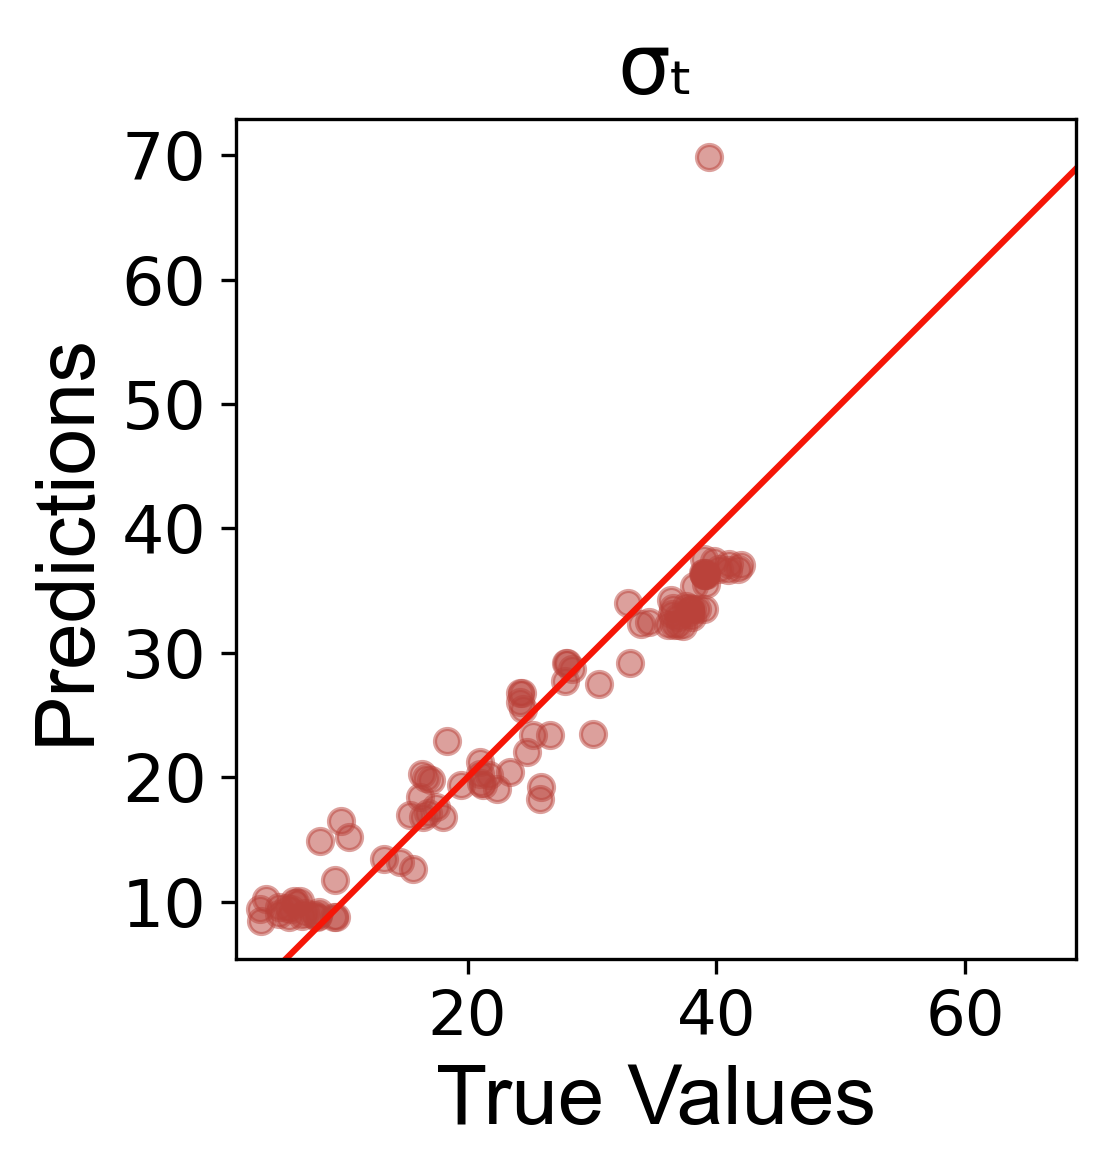

In [26]:
Y_pred = model.predict(norm_test_X)

plot_diff(test_Y[0], Y_pred[0], title='F')
plot_diff(test_Y[1], Y_pred[1], title='E')
plot_diff(test_Y[2], Y_pred[2], title='σ\u209C')

In [27]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [28]:
y_true_0, y_pred_0 = test_Y, Y_pred

print("y1 RMSE:%.4f" % mean_squared_error(y_true_0[0], y_pred_0[0], squared = False))
print("y2 RMSE:%.4f" % mean_squared_error(y_true_0[1], y_pred_0[1], squared = False))
print("y3 RMSE:%.4f" % mean_squared_error(y_true_0[2], y_pred_0[2], squared = False))

y1 RMSE:230.4026
y2 RMSE:412.2014
y3 RMSE:4.6562


In [29]:
print("y1 RMSE:%.4f" % r2_score(y_true_0[0], y_pred_0[0]))
print("y2 RMSE:%.4f" % r2_score(y_true_0[1], y_pred_0[1]))
print("y3 RMSE:%.4f" % r2_score(y_true_0[2], y_pred_0[2]))

y1 RMSE:0.8044
y2 RMSE:0.2049
y3 RMSE:0.8641


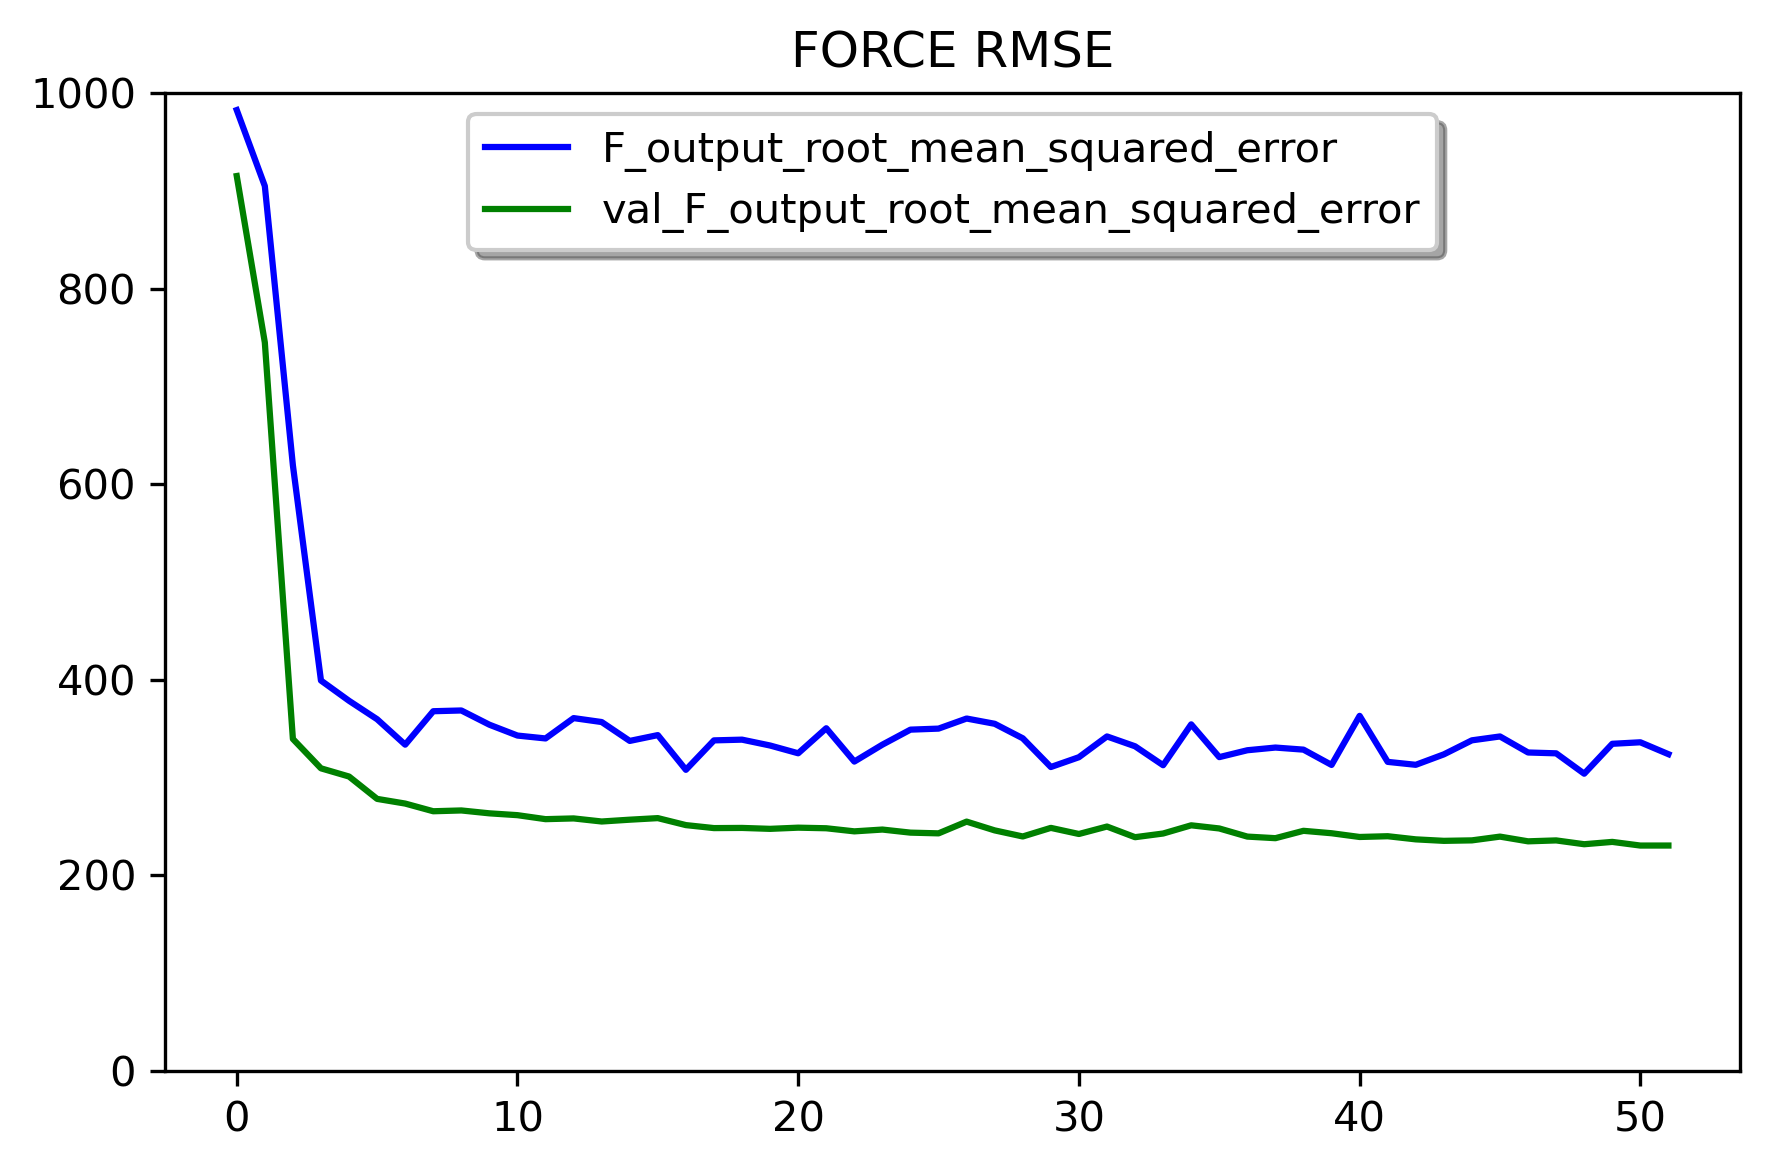

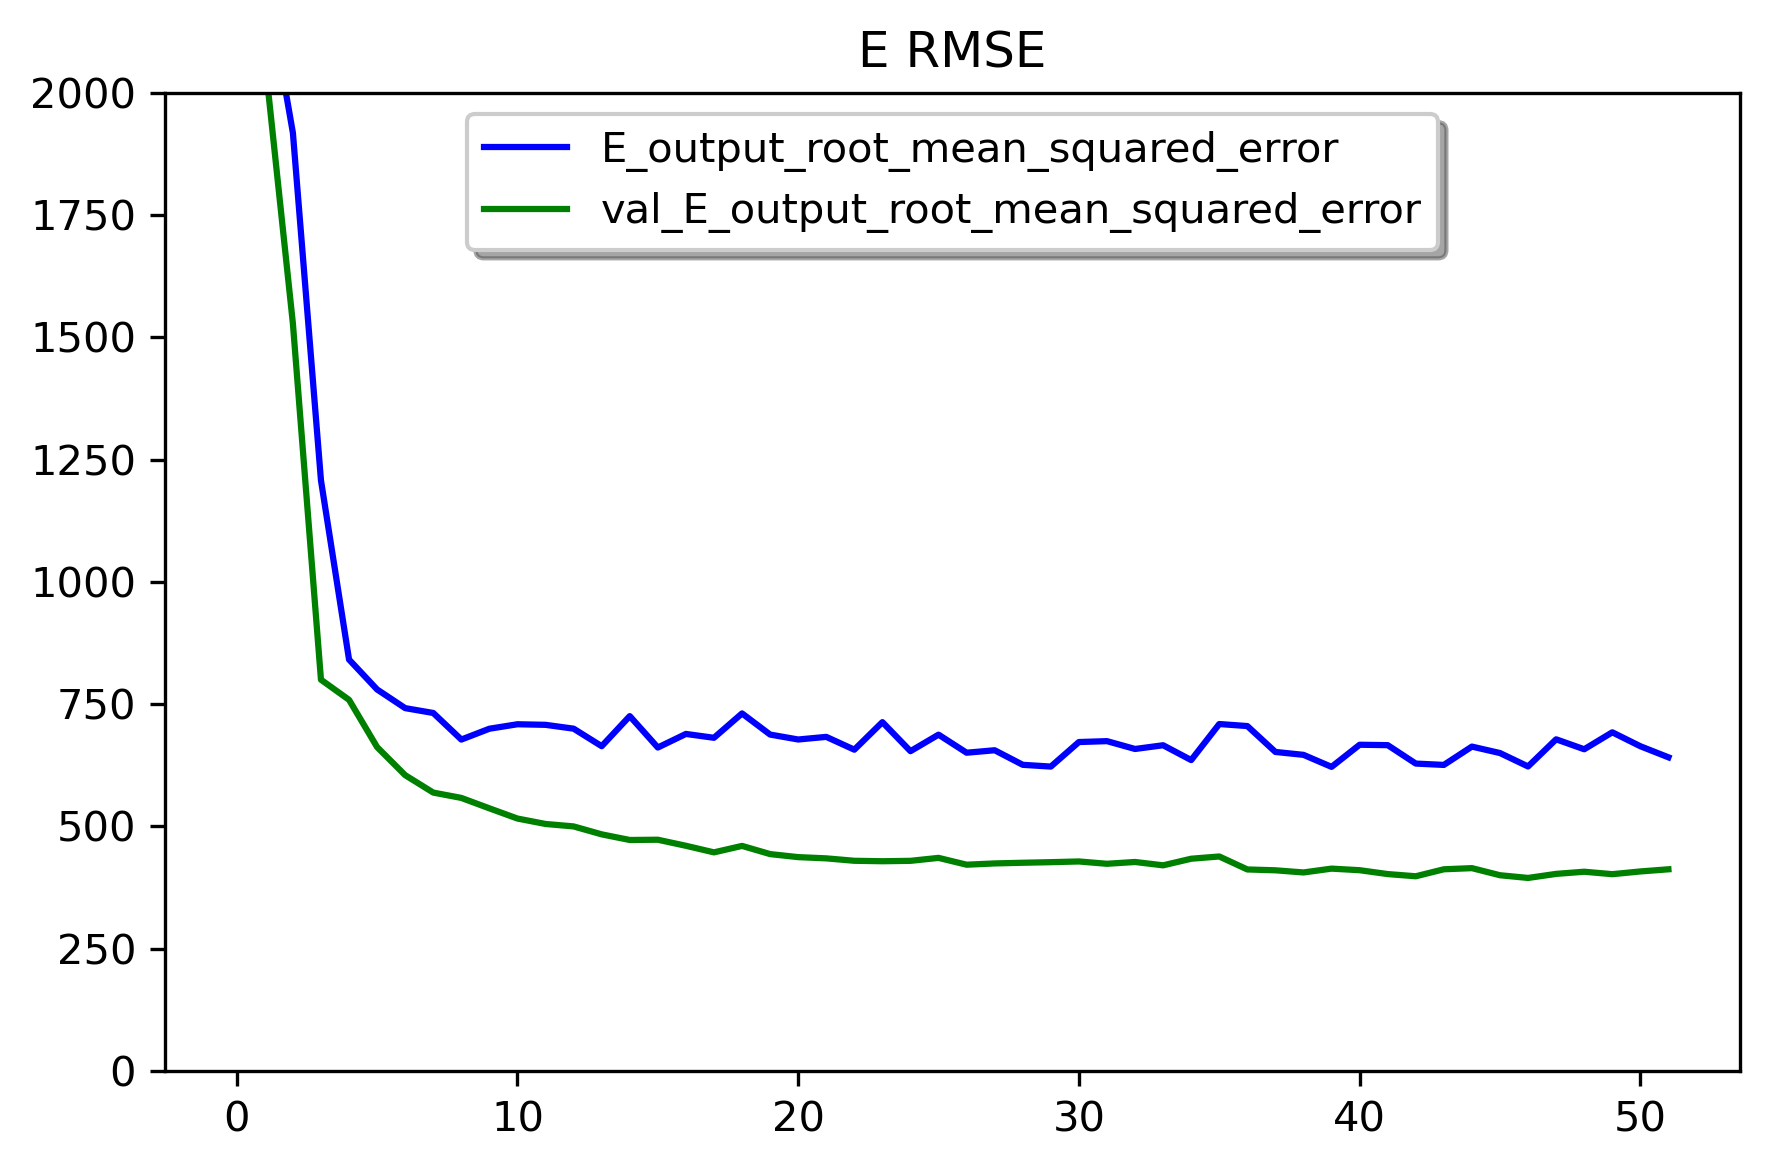

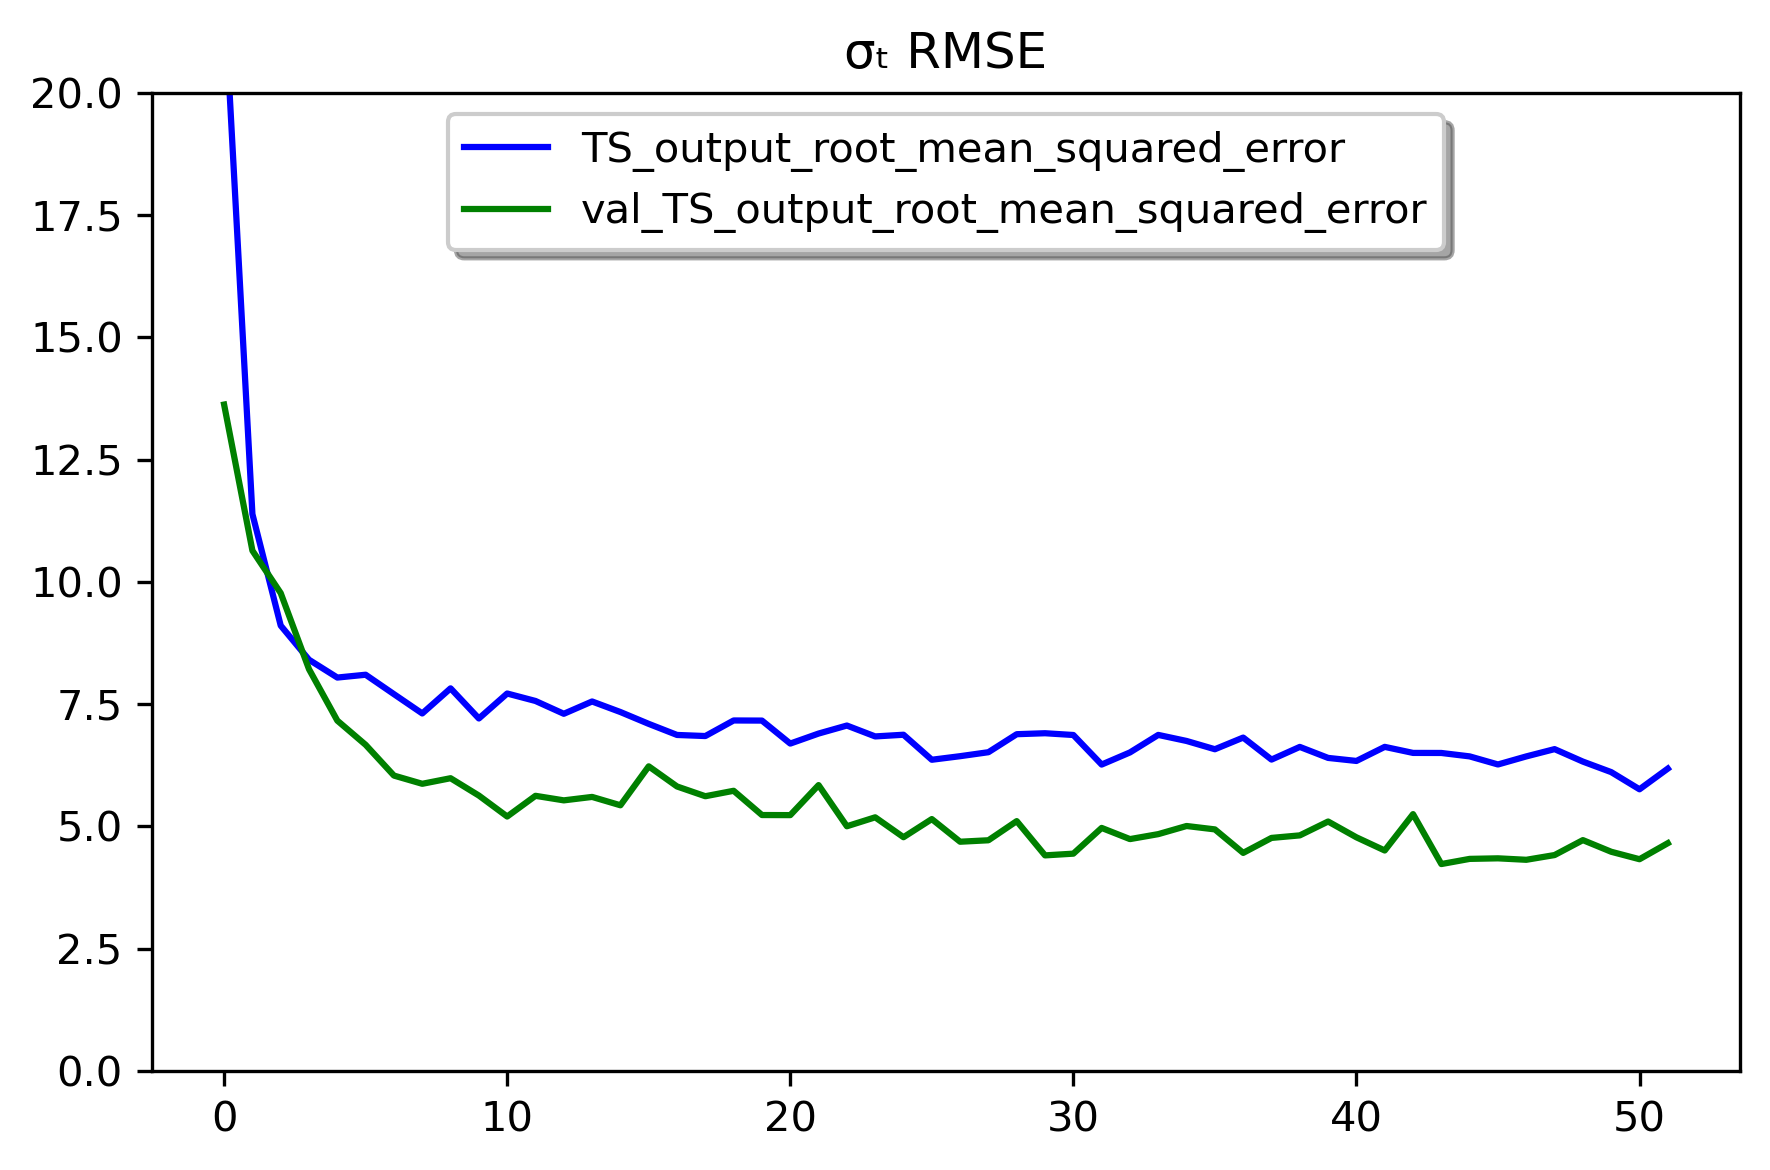

In [30]:
# Plot RMSE
#plot_metrics(metric_name='S_output_root_mean_squared_error', title='SPEED RMSE', ylim=1.5)
plot_metrics(metric_name='F_output_root_mean_squared_error', title='FORCE RMSE', ylim=1000)
plot_metrics(metric_name='E_output_root_mean_squared_error', title='E RMSE', ylim=2000)
plot_metrics(metric_name='TS_output_root_mean_squared_error', title='σ\u209C'+' RMSE', ylim=20)

## Shapley plots

This section below produces Shapley plots to help identify the impact of each feature upon the output.

In [ ]:
import shap

def pairArrays(X):
    output = []
    lengthOfArray = len(X[0])
    for i in range(0, lengthOfArray):
        output.append([X[0][i], X[1][i], X[2][i]])
    return output

def rowsToColumns(X):
    return np.array(pairArrays(model.predict(X)))


shap.initjs()

explainer = shap.KernelExplainer(rowsToColumns, norm_train_X[:50], link = "identity") #Here we include the BG dataset
shapValues = explainer.shap_values(norm_train_X[50:100]) # Explainer dataset

In [ ]:
shap.force_plot(explainer.expected_value[0], shapValues[1], norm_train_X[50:100])

In [ ]:
shap.summary_plot(shapValues[0], norm_train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "σ\u209C"], show=False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shapValues[1], norm_train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "σ\u209C"], show = False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.rcParams['figure.dpi'] = 300
plt.show()

In [ ]:
shap.summary_plot(shapValues[2], norm_train_X, feature_names = ["O", "LH", "ND", "PS", "S_r"],
                  plot_type="bar", class_names= ["F", "E", "σ\u209C"], show = False)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)', fontname='Arial', fontsize=18)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.rcParams['figure.dpi'] = 300
plt.show()

## Make a Prediction and use to calculate Failure Envelope

In [63]:
#train_stats

In [43]:
Fc = pd.read_csv('Failure Criteria test data.csv')
#, encoding= 'unicode_escape'
Fc

,O,LH,ND,PS,S_r
0,0,0.1,0.3,1200,0.96
1,90,0.1,0.3,1200,0.96


In [44]:
Fc_norm = norm(Fc)
Fc_norm

,O,LH,ND,PS,S_r
0,-0.972739,-1.059032,-0.969474,-1.264327,0.594845
1,1.025320,-1.059032,-0.969474,-1.264327,0.594845


In [45]:
Fc_norm = np.array(norm(Fc))
Fc_norm

array([[-0.973, -1.059, -0.969, -1.264,  0.595],
       [ 1.025, -1.059, -0.969, -1.264,  0.595]])

In [46]:
model.predict(FE_norm)

[array([[528.695],
        [571.529]], dtype=float32),
 array([[2420.315],
        [2282.511]], dtype=float32),
 array([[36.426],
        [22.947]], dtype=float32)]

## Validation

In [60]:
FC = pd.read_csv('verification_data_input.csv')

FC = FC.loc[0:7]

In [53]:
exp = pd.read_csv('verification_data_exp result.csv')
exp

,F,E,Ts
0,517.398067,2417.93,37.49
1,499.294211,2354.26,37.53
2,507.527749,2038.77,36.50
3,522.450344,2338.16,35.73
4,582.356721,2053.77,37.03
5,579.558407,2083.33,37.03
6,597.970057,2179.39,35.81
7,603.745676,2022.44,35.70


In [61]:
FC_norm =norm(FC)
FC_norm

,O,LH,ND,PS,S_r
0,-0.972739,-0.234376,-0.064314,-0.032419,0.585875
1,-0.972739,-0.234376,-0.064314,-0.032419,0.615328
2,-0.972739,-0.234376,-0.064314,-0.032419,0.628885
3,-0.972739,-0.234376,-0.064314,-0.032419,0.607069
4,-0.972739,-0.234376,-0.064314,-0.032419,0.681265
5,-0.972739,-0.234376,-0.064314,-0.032419,0.627975
6,-0.972739,-0.234376,-0.064314,-0.032419,0.658380
7,-0.972739,-0.234376,-0.064314,-0.032419,0.637160


In [62]:
ANN = np.array(model.predict(FC_norm)).reshape(3,8)
np.transpose(np.abs(np.transpose(ANN) - np.array(exp))/np.array(exp))

array([[0.237, 0.21 , 0.224, 0.245, 0.325, 0.32 , 0.342, 0.348],
       [0.078, 0.052, 0.096, 0.046, 0.091, 0.072, 0.027, 0.105],
       [0.124, 0.123, 0.097, 0.079, 0.105, 0.11 , 0.077, 0.076]])